In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11.tools import df_from_dict_of_tuples
from e11.fit import Gaussian

`e11.fit` contains classes that simplify fitting common functions to data.  The classes use statistical features of the data to make intelligent initial guesses at the fit parameters (so you don't have to).  This is particularly useful for bulk fitting operations.

## Generate data

In [2]:
def gauss(x, x0, amp, sigma, offset):
    """ 1D gaussian """
    return amp * np.exp(-0.5 * (((x - x0) / sigma)**2.0)) + offset

variables = ('x0', 'amp', 'sigma', 'offset')

# generate 1d data
nx = 500
xvals = np.arange(nx)
arr = []
std = 1.2
labels = [-1.4, -0.5, 0.4]
data_pars = {}
for lbl, x0, amp, sigma in zip(labels,
                               [100, 200, 300],
                               [18, 12, 6],
                               [40, 50, 60]):
    p0 = [x0, amp, sigma, 2]
    data_pars[lbl] = dict(zip(variables, p0))
    yvals = gauss(xvals, *p0) + std * np.random.randn(nx)
    arr.append(yvals)
arr = np.array(arr)
data_pars = pd.DataFrame.from_dict(data_pars, orient="index")

In [3]:
data_pars

,x0,amp,sigma,offset
-1.4,100,18,40,2
-0.5,200,12,50,2
0.4,300,6,60,2


## Fit data

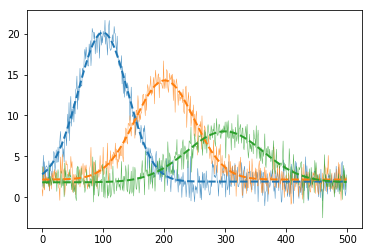

In [4]:
fig, ax = plt.subplots()

fit_pars = {}
reduced_chi_sq = {}
for lbl, yvals in zip(labels, arr):
    # data
    p = ax.plot(xvals, yvals, lw=0.5, alpha=0.8, zorder=5)
    color = p[0].get_color()
    # fit
    g = Gaussian(xvals, yvals)
    popt, perr = g.fit()
    ax.plot(g.xdata, g.best_fit, color=color, ls="--", lw=2, zorder=10)
    # reduced chi_sq
    reduced_chi_sq[lbl] = np.sum(g.residuals**2 / (std**2)) / (nx - len(g.variables))
    # record
    fit_pars[lbl] = g.asdict()

fit_pars = df_from_dict_of_tuples(fit_pars)
plt.show()

In [5]:
pd.Series(reduced_chi_sq)

-1.4    1.046889
-0.5    0.977980
 0.4    0.916913
dtype: float64

In [6]:
fit_pars

x0                  amp                sigma            \
           value     error      value     error      value     error   
-1.4   99.612250  0.457046  18.203157  0.185774  40.542181  0.505181   
-0.5  200.969107  0.723714  12.105811  0.166047  48.303227  0.841362   
 0.4  299.385315  1.554206   6.216475  0.147707  62.651100  1.985041   

        offset            
         value     error  
-1.4  1.922300  0.071091  
-0.5  2.174064  0.076087  
 0.4  1.836446  0.087958

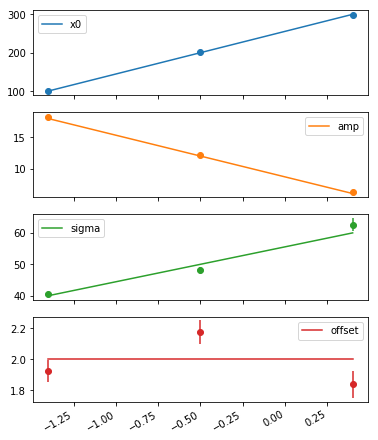

In [7]:
axes = data_pars.plot(subplots=True, figsize=(6, 8))

for i, var in enumerate(g.variables):
    yvals = fit_pars[(var, "value")]
    yerr = fit_pars[(var, "error")]
    axes[i].errorbar(yvals.index, yvals.values, yerr=yerr.values, c="C%d"%i, ls="", marker="o")
plt.show()

# Example 1D fit functions

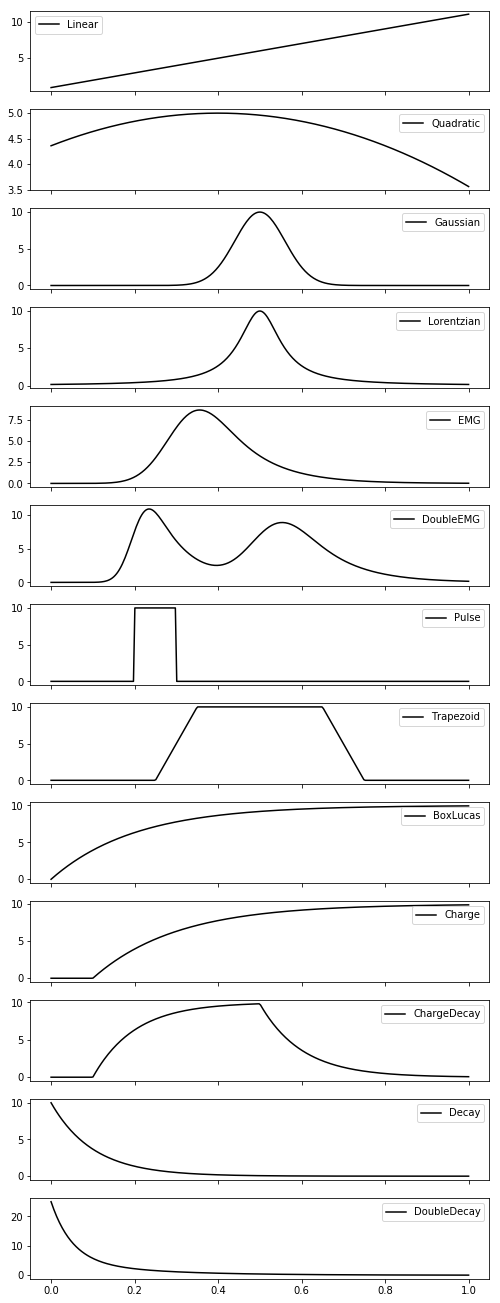

In [8]:
import e11.fit as fit
fit_funcs = [fit.Linear, fit.Quadratic, fit.Gaussian, fit.Lorentzian,
             fit.EMG, fit.DoubleEMG, fit.Pulse, fit.Trapezoid,
             fit.BoxLucas, fit.Charge, fit.ChargeDecay, fit.Decay, fit.DoubleDecay]

fig, ax = plt.subplots(len(fit_funcs), 1, figsize=(7, 1.4*len(fit_funcs)), sharex=True)

xvals = np.linspace(0, 1, 300)
yvals = None

params = {"Linear":[10, 1],
          "Quadratic":[0.4, -4, 5],
          "Gaussian":[0.5, 10, .06, 0],
          "Lorentzian":[0.5, 10, .06, 0],
          "EMG":[0.3, 10, .06, 0.1, 0],
          "DoubleEMG":[0.2, 10, .03, 0.08, 0.5, 10, .06, 0.1, 0],
          "Pulse":[0.2, 0.1, 10, 0],
          "Trapezoid":[0.3, 0.4, 0.1, 10, 0], 
          "BoxLucas": [0.2, 10, 0],
          "Charge": [0.1, 0.2, 10, 0],
          "ChargeDecay": [0.1, 0.4, 0.1, 10, 0],
          "Decay": [10, 0.1],
          "DoubleDecay": [20, 0.05, 5, 0.2]}

for i, obj in enumerate(fit_funcs):
    f = obj(xvals, yvals)
    name = f.__class__.__name__
    ax[i].plot(f.xdata, f.func(f.xdata, *params[name]), c='k', label=name)
    ax[i].legend()

plt.tight_layout()
plt.show()

{'x0': (1.1000271489390134, 2.1740380852026777e-05), 'amp': (-3.9997428090369653, 0.0003137642346396204), 'offset': (4.999949681034339, 0.00013922481332374054)}


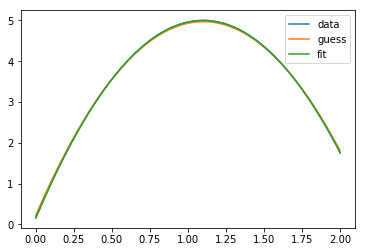

In [9]:
# quadratic fit
xvals = np.linspace(0, 2, 1000)
pars = [1.1, -4, 5]
yvals = pars[1] * (xvals - pars[0])**2.0 + pars[2] + 0.003*np.random.randn(len(xvals))

f = fit.Quadratic(xvals, yvals)
popt, perr = f.fit()
print(f.asdict())

# plot
fig, ax = plt.subplots()
ax.plot(xvals, yvals, label="data")
ax.plot(f.xdata, f.func(f.xdata, *f.approx()), label="guess")
ax.plot(f.xdata, f.best_fit, label="fit")
ax.legend()
plt.show()